# Clasificación de formas parecidas
Vamos a descargar primero las librerías necesarias. Dado que trabajaremos con gráficas, recomendamos el uso de la librería **networkx**, la cual necesitamos descargar. Además de que, para usar todos los recursos de la computadora, haremos un poco de cómuto paralelo con la librería **multiprocessing**

In [ ]:
conda install networkx multiprocessing

## El algoritmo húngaro, versión matricial
Primero importamos las librerías necesarias.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import time as t
import networkx as nx

from multiprocessing import Pool

Daremos una versión híbrida de este algoritmo que resolverá el paso 3 como un problema de mínimo camino de aumento de una gráfica bipartita. Para ello necesitaremos una función para encontrar un mínimo camino de aumento, haciendo búsqueda de amplitud.

In [9]:
def findAugmPathBreadth(Gf):
    level = [(0,-1)]
    marked = [(0,-1)]
    C = [0]
    while level != []:
        next_level = []
        for u in level:
            for i in range(len(Gf[0])):
                if( Gf[u[0]][i] != 0 and i not in C ):
                    if( i == len(Gf[0])-1 ):
                        P = [i]
                        aux = u[0]
                        while( aux != -1 ):
                            P.append(aux)
                            for c in marked:
                                if(aux == c[0]):
                                    aux = c[1]
                                    marked.remove(c)
                        return [P[len(P)-i-1] for i in range(len(P))]
                    marked.append((i,u[0]))
                    C.append(i)
                    next_level.append((i,u[0]))
        level = [next_level[i] for i in range(len(next_level))]
    return []

Ahora los 3 pasos del algoritmo, recordemos que el paso número 4 es simplemente repetir el paso 3. 

In [10]:
def hungarianMethodStep1(A):
    for i in range(len(A[0])):
        aux = min(A[i])
        A[i] -= aux
    return A

def hungarianMethodStep2(A):
    At = np.transpose(A)
    for i in range(len(A[0])):
        aux = min(At[i])
        for j in range(len(A[0])): A[j][i] -= aux
    return A

def hungarianMethodStep3(A):
    B = A.copy()
    n = len(A[0])
    M = []
    Z =np.zeros((2*n+2,2*n+2))
    for i in range(n):
        for j in range(n):
            if(B[i][j] == 0): Z[1+i][n+j+1] = 1
    #inicializa aristas de s y t
    for i in range(n):
        Z[0][1+i] = 1
        Z[n+1+i][2*n+1] = 1
    P = findAugmPathBreadth(Z)
    while(P != []):
        for j in range(len(P)-1):
            Z[P[j]][P[j+1]] -= 1
            Z[P[j+1]][P[j]] += 1
        P = findAugmPathBreadth(Z)
    mod = 0
    for i in range(n,2*n+1):
        for j in range(1,n+1):
            if(Z[i][j] != 0):
                M.append((i-n,j))
                mod += 1
    if(mod == n): return M
    columns = []
    rows = []
    for i in range(1,n+1):
        if(i not in [M[j][1] for j in range(len(M))]): rows.append(i)
    for k in rows:
        for i in range(n):
            if(B[k-1][i] == 0 and i+1 not in columns):
                columns.append(i+1)
                for j in range(len(M)):
                    if(M[j][0] == i+1 and M[j][1] not in rows): rows.append(M[j][1])
    Left = []
    for i in range(1,n+1):
        for j in range(1,n+1):
            if(j not in columns and i in rows): Left.append((B[i-1][j-1],i-1,j-1))
    val = min([Left[i][0] for i in range(len(Left))])
    for K in Left: B[K[1]][K[2]] -= val

    M1 = hungarianMethodStep3(B)
    return M1

def hungarianAlgorithm(A):
    hungarianMethodStep1(A)
    hungarianMethodStep2(A)
    return hungarianMethodStep3(A)

Ahora unos ejemplos:

[(1, 3), (2, 1), (3, 2), (4, 5), (5, 4)]


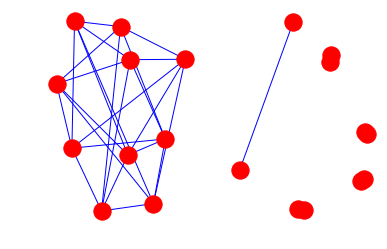

In [26]:
A1 = np.zeros([5,5])

A1[0] = [13, 5,89,45,12]
A1[1] = [45,71, 6,26,54]
A1[2] = [ 5,16,45,38,34]
A1[3] = [15, 7,48,52, 8]
A1[4] = [45,61,12, 1, 9]

G1 = nx.Graph()
for i in range(5):
    for j in range(5):
        G1.add_weighted_edges_from([('p'+str(i),'q'+str(j),A1[i][j])])

plt.subplot(121)
nx.draw(G1, nodecolor='r', edge_color='b')

B = hungarianAlgorithm(A1)
print(B)
G2 = nx.Graph()

for j in range(5):
    G2.add_weighted_edges_from([('p'+str(B[j][0]),'q'+str(B[j][1]),A1[i][j])])
plt.subplot(122)
nx.draw(G2, nodecolor='r', edge_color='b',sorted_axis = -1)

## Apareamiento de formas

Ahora procederemos a mostrar el algoritmo de apareamiento de figuras, haciendo la observación de que no usaremos el algoritmo húngaro implementado anteriormente pues tiene complejidad cuártica. En su lugar usaremos la implementación del paquete Networkx, usando la función de máximos pesos. Tendremos que tener cuidado de modificar los valores de la matriz, pues este algoritmo no admite números negativos y encuentra un máximo en vez de un mínimo. 

In [29]:
def hungarianAlgorithm(A):
    G = nx.Graph()
    edgeWList = []
    maxValue = max([max(A[i]) for i in range(len(A))])
    for i in range(len(A)):
        edgeWList.append([])
        for j in range(len(A)):
            edgeWList[i].append(('p'+str(i),'q'+str(j),maxValue-A[i][j]))
    for i in range(len(A)):
        G.add_weighted_edges_from(edgeWList[i])
    matchSet = nx.max_weight_matching(G)
    matchIndex = [ (int(Edge[0][1:]),int(Edge[1][1:])) for Edge in matchSet]
    return matchIndex



In [30]:
def norm(p,q):
    N = ( (p[0]-q[0])**2 + (p[1]-q[1])**2 )**(0.5)
    #print(N)
    return N

def histograma(i,P):
    radBins = 8        # Cantidad de cajas radiales (anillos)
    angleBins = 15      # Cantidad de cajas angulares (quesitos)
    PA = 1.0*(np.copy(P))
    """
    X =[0,0]
    for i in range(len(PA)):
        X[0] += 1.0*PA[i][0]/len(PA)
        X[1] += 1.0*PA[i][1]/len(PA)
    """
    # Normaliza la forma con centro en X
    Z = P[i]
    #print(PA)
    Max = max([norm(P[j],Z) for j in range(len(P))])
    for j in range(len(PA)):
        a = float(P[j][0]-Z[0])
        b = float(P[j][1]-Z[1])
        PA[j][0] = a/(Max+1)
        PA[j][1] = b/(Max+1)
    # Inicializa el histograma
    H = np.zeros([radBins,angleBins])

    # Llena los bins (matriz de presencia)
    for j in range(len(PA)):
        if(j != i):
            theta = np.arctan2(PA[j][1],PA[j][0])
            r = norm(PA[i],PA[j])*(2**(radBins))
            #print(theta)
            if(r != 0):
                if np.log2(r) < 0:
                    H[0][int(1.0*angleBins*((theta+np.pi)%(2*np.pi))/(2*np.pi))] += 1.0
                else:
                    H[int(np.log2(r))][int(1.0*angleBins*((theta+np.pi)%(2*np.pi))/(2*np.pi))] += 1.0
    return H/float(sum(sum(H)))

In [31]:
def costFunction(ptInFirstShape,ptInSecondShape,H):
    #print(shape2)

    H1 = H[0][ptInFirstShape]
    H2 = H[1][ptInSecondShape]

    C = 0
    for k1 in range(len(H1)):
        for k2 in range(len(H1[0])):
            if H1[k1][k2]+H2[k1][k2] != 0:
                C += ((H1[k1][k2]-H2[k1][k2])**2)/(H1[k1][k2]+H2[k1][k2])
    return C/2.0


In [32]:
def calculaHistogramas(X,Y):
    size = len(X)
    H = [[],[]]
    for i in range(size):
        H[0].append(histograma(i,X))
        H[1].append(histograma(i,Y))
    return H


In [39]:
def shapeContext(X, Y):
    size = len(X)
    C = np.zeros([size,size])
    #print(X, Y)

    H = calculaHistogramas(X,Y)

    for i in range(size):
        for j in range(size):
            C[i][j] = costFunction(i,j,H)
    return C

def shapenorm(X,Y):
    sizeX = len(X)
    sizeY = len(Y)
    size = 0
    if sizeX > sizeY:
        for _ in range(sizeX-sizeY):
            Y.append(Y[0])
        size = sizeX
    elif sizeY > sizeX:
        for _ in range(sizeY-sizeX):
            X.append(X[0])
        size = sizeY
    else: size = sizeX


    C = shapeContext(X,Y)
    A = hungarianAlgorithm(C)
    norm = 0
    for (i,j) in A:
        norm += C[i-1][j-1]/(size)
    return [A,norm]


# Un ejemplo. 20 imágenes.

In [71]:
def saveNormVector(fixedIndex,scale=10):
        Normas = []
        auxMin = 10000
        index2 = 0
        cosa1 = np.array(sio.loadmat("data/"+str(fixedIndex)+".mat")['x'])
        for k in range(fixedIndex+1,23):
            cosa2 = np.array(sio.loadmat("data/"+str(k)+".mat")['x'])

            Dis1 = len(cosa1)
            Dis2 = len(cosa2)

            scale1 = scale
            scale2 = scale
            if Dis1 > Dis2:
                for i in range(scale):
                    if Dis1//scale <= Dis2//(scale-i):
                        break
                    else: scale2 = (scale-i)
            elif Dis1 < Dis2:
                for i in range(scale):
                    if Dis2//scale <= Dis1//(scale-i):
                        break
                    else: scale1 = (scale-i)
            print(Dis1//scale1,Dis2//scale2)

            t1 = t.time()
            Res = shapenorm([[int(cosa1[i][0]),int(cosa1[i][1])] for i in range(0,len(cosa1),scale1)],[[int(cosa2[i][0]),int(cosa2[i][1])] for i in range(0,len(cosa2),scale2)])
            t2 = t.time()


            A = Res[0]
            dist = Res[1]
            Normas.append(dist)
            if auxMin > dist:
                auxMin =  dist
                index2 = k

            print('La distancia entre las imágenes '+str(fixedIndex)+' y '+str(k)+' es: ', dist)
            print("Se tardó ", t2-t1, " segundos")
        file = open('LasDistancias'+str(fixedIndex)+'.txt',"w+")
        for k in range(len(Normas)):
            file.write("D("+str(j)+","+str(k+fixedIndex)+") = "+str(Normas[k])+"\n")
        file.close()
        
        cosa1 = np.array(sio.loadmat("data/"+str(fixedIndex)+".mat")['x'])
        cosa2 = np.array(sio.loadmat("data/"+str(index2)+".mat")['x'])
        
        Res = shapenorm([[int(cosa1[i][0]),int(cosa1[i][1])] for i in range(0,len(cosa1),scale1)],[[int(cosa2[i][0]),int(cosa2[i][1])] for i in range(0,len(cosa2),scale2)])

        A = Res[0]
        dist = Res[1]
        Pl = []

        for i in range(len(A)):
            try:
                Pl.append((cosa1[scale1*A[i][1]-scale1][0],cosa1[scale1*A[i][1]-scale1][1]))
            except: Pl.append((cosa1[0][0],cosa1[0][1]))
            try:
                Pl.append((cosa2[scale2*A[i][0]-scale2][0],cosa2[scale2*A[i][0]-scale2][1]))
            except: Pl.append((cosa2[0][0],cosa2[0][1]))
        for i in range(0,len(Pl),2):
            plt.subplot(1,1,1),plt.plot([Pl[i][0],Pl[i+1][0]],[Pl[i][1],Pl[i+1][1]], '--')

        plt.subplot(1,1,1),plt.plot(cosa1[:,0],cosa1[:,1],'.b')
        plt.subplot(1,1,1),plt.plot(cosa2[:,0],cosa2[:,1],'.r')

        plt.show()

        
        return Normas

Usaremos multiprocessing para realizar estas pruebas.

17 16
30 31
17 17
25 26
La distancia entre las imágenes 4 y 5 es:  0.6983369276489915
Se tardó  0.2300434112548828  segundos
La distancia entre las imágenes 3 y 4 es:  0.7395323367413661
Se tardó  0.2573370933532715  segundos
24 26
17 16
La distancia entre las imágenes 3 y 5 es:  0.37799979840421016
Se tardó  0.18804025650024414  segundos
24 26
La distancia entre las imágenes 5 y 6 es:  0.49032968428163826
Se tardó  0.7172896862030029  segundos
29 31
La distancia entre las imágenes 6 y 7 es:  0.5717804617598761
La distancia entre las imágenes 4 y 6 es:  0.592412566130341
Se tardó  1.0199520587921143  segundos
26 25
Se tardó  0.7534663677215576  segundos
28 31
La distancia entre las imágenes 3 y 6 es:  0.4789692345654148
Se tardó  0.7799394130706787  segundos
30 31
La distancia entre las imágenes 5 y 7 es:  0.29382374316315935
Se tardó  0.9751737117767334  segundos
19 20
La distancia entre las imágenes 6 y 8 es:  0.5223109256065791
Se tardó  0.8836746215820312  segundos
28 29
La distanc

/home/theStampedeDOTsh/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/theStampedeDOTsh/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


La distancia entre las imágenes 4 y 22 es:  0.6507681338822722
Se tardó  0.582207202911377  segundos


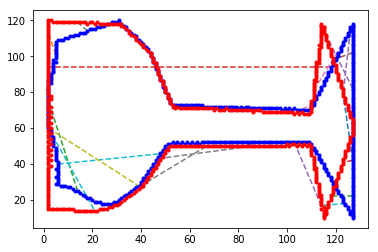

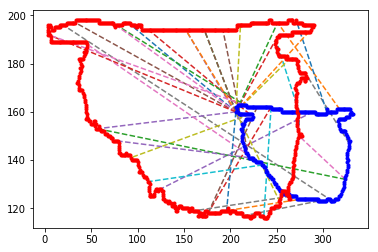

/home/theStampedeDOTsh/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/theStampedeDOTsh/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


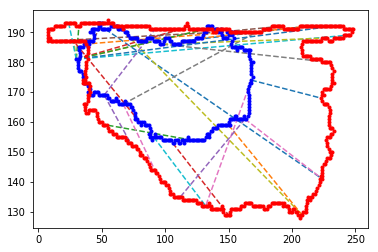

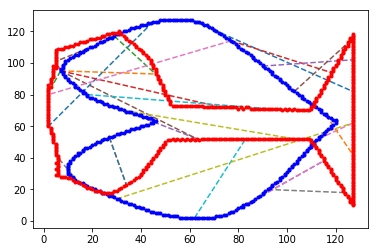

17 16
30 31
31 29
25 26
La distancia entre las imágenes 4 y 5 es:  0.6983369276489915
Se tardó  0.2325751781463623  segundos
24 26
La distancia entre las imágenes 5 y 6 es:  0.49032968428163826
Se tardó  0.7609095573425293  segundos
29 31
La distancia entre las imágenes 7 y 8 es:  0.3399946351631903
Se tardó  0.9053208827972412  segundos
31 30
La distancia entre las imágenes 6 y 7 es:  0.5717804617598761
La distancia entre las imágenes 4 y 6 es:  0.592412566130341
Se tardó  1.076341152191162  segundos
Se tardó  0.8268554210662842  segundos
28 31
26 25
La distancia entre las imágenes 6 y 8 es:  0.5223109256065791
Se tardó  0.65065598487854  segundos
28 29
La distancia entre las imágenes 5 y 7 es:  0.29382374316315935
Se tardó  0.9844586849212646  segundos
19 20
La distancia entre las imágenes 5 y 8 es:  0.32451182893916886
Se tardó  0.3407707214355469  segundos
27 29
La distancia entre las imágenes 7 y 9 es:  0.6568889963500203
La distancia entre las imágenes 4 y 7 es:  0.65227803424424

/home/theStampedeDOTsh/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


La distancia entre las imágenes 4 y 22 es:  0.6507681338822722
Se tardó  0.47051453590393066  segundos


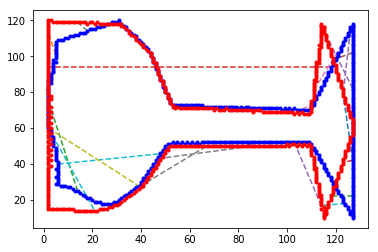

La distancia entre las imágenes 7 y 22 es:  0.6297959954980569
Se tardó  0.9996974468231201  segundos


/home/theStampedeDOTsh/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/theStampedeDOTsh/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


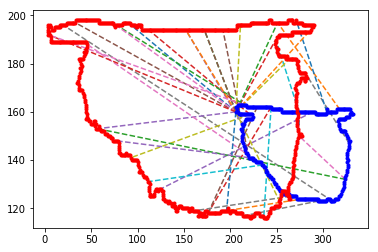

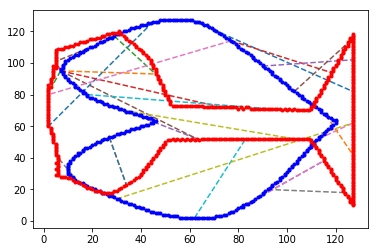

/home/theStampedeDOTsh/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


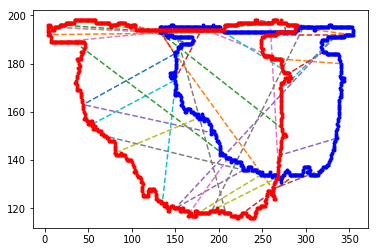

30 31
25 26
27 29
31 29
La distancia entre las imágenes 5 y 6 es:  0.49032968428163826
Se tardó  1.2463669776916504  segundos
29 31
La distancia entre las imágenes 8 y 9 es:  0.630040621803347
Se tardó  2.4014854431152344  segundos
27 28
La distancia entre las imágenes 6 y 7 es:  0.5717804617598761
La distancia entre las imágenes 7 y 8 es:  0.3399946351631903
Se tardó  2.8603062629699707  segundos
Se tardó  2.8878226280212402  segundos
31 30
26 25
La distancia entre las imágenes 5 y 7 es:  0.29382374316315935
Se tardó  3.855687379837036  segundos
19 20
La distancia entre las imágenes 6 y 8 es:  0.5223109256065791
Se tardó  2.4981741905212402  segundos
28 29
La distancia entre las imágenes 8 y 10 es:  0.2929147951030346
Se tardó  2.995168685913086  segundos
25 27
La distancia entre las imágenes 5 y 8 es:  0.32451182893916886
Se tardó  0.5666947364807129  segundos
27 29
La distancia entre las imágenes 7 y 9 es:  0.6568889963500203
Se tardó  2.9742677211761475  segundos
31 29
La distancia

/home/theStampedeDOTsh/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Se tardó  1.6037843227386475  segundos
26 25
La distancia entre las imágenes 5 y 22 es:  0.5604979089649896
Se tardó  0.5532224178314209  segundos


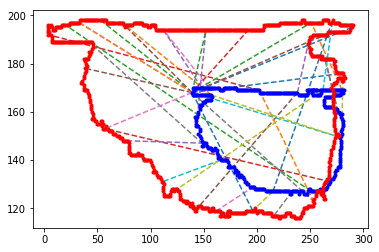

La distancia entre las imágenes 6 y 22 es:  0.42635413858955024
Se tardó  0.6794569492340088  segundos
La distancia entre las imágenes 7 y 21 es:  0.1605125841769738
Se tardó  1.5683066844940186  segundos
31 29


/home/theStampedeDOTsh/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


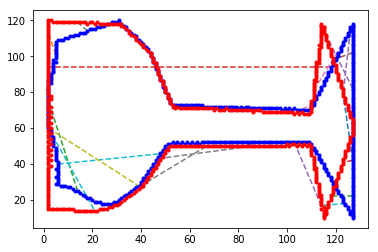

/home/theStampedeDOTsh/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


La distancia entre las imágenes 7 y 22 es:  0.6297959954980569
Se tardó  0.8086340427398682  segundos


Process ForkPoolWorker-140:
Process ForkPoolWorker-138:
Process ForkPoolWorker-137:
Process ForkPoolWorker-139:
Traceback (most recent call last):
  File "/home/theStampedeDOTsh/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/theStampedeDOTsh/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/theStampedeDOTsh/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/theStampedeDOTsh/anaconda3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/theStampedeDOTsh/anaconda3/lib/python3.6/multiprocessing/pool.py", line 47, in starmapstar
    return list(itertools.starmap(args[0], args[1]))
  File "/home/theStampedeDOTsh/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._ar

In [ ]:
scale = 20
for J in range(5):
    with Pool(4) as P:
        aux = P.starmap(saveNormVector,[(J+3,scale),(J+4,scale),(J+5,scale),(J+6,scale)])
        for k in range(4):
            Normas.append(aux[k])